# Load the gmm trained

In [ ]:
# Notebook-friendly imports
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
from types import SimpleNamespace

import torch

# our utils
from utils import (
    get_dataset, build_model, eval_acc, parse_batch_spec,
    build_encoder, load_decoder_backend, g_ball
)
from fit_gmm import GMM  # our GMM class (including compute_pr_on_clean_correct)

# path to GMM package & classifier ckpt
PKG_PATH  = "./log/gmm_ckp/x_dep/dec/gmm_CWlike_resnet18_cifar10_cov(full)_L(l2_0p5000)_K(20)_Dec(ae).pt"
CLF_CKPT  = "./model_zoo/trained_model/sketch/resnet18_cifar10.pth"

# optional settings
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
S_SAMPLES = 10        # PR number of MC samples per image
BATCH_IDX = "0-20"         # the batch index，e.g. "0,3,5-10"；"" means all batches
BATCH_SIZE= 128        # the batch size for the evaluation DataLoader

device = torch.device(DEVICE)

if not os.path.isfile(PKG_PATH):
    raise FileNotFoundError(PKG_PATH)


dataset, num_classes, out_shape = get_dataset('cifar10', train=False)
gmm, enc_loaded, dec_loaded, meta = GMM.load_package(
    filepath=PKG_PATH,
    device=device,
    build_encoder_fn=build_encoder,
    load_decoder_backend_fn=load_decoder_backend,
    out_shape=out_shape
)

# use snapshot to rebuild dataset, model, feat_extractor
snap = meta.get("args_snapshot") or {}
eva  = SimpleNamespace(**snap)  # eva.dataset / eva.arch / eva.gamma / eva.norm / ...

# addtional settings (override snapshot) for classfier ckpt & eval
clf_ckpt = getattr(eva, "clf_ckpt", None) or CLF_CKPT
print("Loaded package:", PKG_PATH)
print("Snapshot keys:", list(snap.keys()))


Files already downloaded and verified


Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/ae/ae-cifar10/checkpoints/epoch%3D96.ckpt`


[GMM] package loaded from: ./log/gmm_ckp/x_dep/dec/gmm_CWlike_resnet18_cifar10_cov(full)_L(l2_0p5000)_K(20)_Dec(ae).pt
Loaded package: ./log/gmm_ckp/x_dep/dec/gmm_CWlike_resnet18_cifar10_cov(full)_L(l2_0p5000)_K(20)_Dec(ae).pt
Snapshot keys: ['dataset', 'arch', 'norm', 'gamma', 'mc', 'num_modes', 'cov_type', 'cov_rank', 'xdep', 'use_decoder', 'encoder_backend', 'decoder_backend', 'freeze_encoder', 'freeze_decoder', 'latent_dim', 'gan_class', 'gan_truncation']


# load dataset and model

In [18]:
dataset, num_classes, out_shape = get_dataset(eva.dataset, train=False)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)
print("Dataset:", eva.dataset, "num_classes:", num_classes, "out_shape:", out_shape)


model, feat_extractor = build_model(eva.arch, num_classes, device)

# load classifier ckpt
state = torch.load(clf_ckpt, map_location="cpu", weights_only=False)
if "state_dict" in state:
    state = state["state_dict"]
state = {k.replace("module.", ""): v for k, v in state.items()}
missing, unexpected = model.load_state_dict(state, strict=False)
print(f"[clf] loaded. missing={len(missing)} unexpected={len(unexpected)}")

# freeze & eval()
model = model.to(device).eval();  [p.requires_grad_(False) for p in model.parameters()]
feat_extractor = feat_extractor.to(device).eval(); [p.requires_grad_(False) for p in feat_extractor.parameters()]

# check accuracy on clean data
acc_clean = eval_acc(model, dataset, device)
print(f"[clean acc] {acc_clean*100:.2f}%")


Files already downloaded and verified
Dataset: cifar10 num_classes: 10 out_shape: (3, 32, 32)
[clf] loaded. missing=0 unexpected=0
[clf] accuracy=86.78%
[clean acc] 86.78%


# Compute PR

In [19]:
from utils import compute_pr_on_clean_correct_old
# whether use encoder & decoder and xdep
# all from the loaded GMM package
xdep        = meta["gmm_config"]["xdep"] 
use_decoder = meta["decoder_info"].get("use_decoder", False)

if xdep:
    if eva.encoder_backend == "classifier":
        encoder_for_eval = feat_extractor
    else:
        encoder_for_eval = enc_loaded
else:
    encoder_for_eval = None

decoder_for_eval = dec_loaded if use_decoder else None

# the batch to be evaluated
pr_sel = parse_batch_spec(BATCH_IDX)

# compute PR (on clean correct samples)


pr, n_used, clean_acc = gmm.compute_pr_on_clean_correct(
    model=model,
    loader=loader,
    out_shape=out_shape,
    encoder=encoder_for_eval,
    decoder=decoder_for_eval,
    S=S_SAMPLES,
    gamma=eva.gamma,          # from training snapshot
    norm_type=eva.norm,       # from training snapshot
    use_decoder=use_decoder,
    batch_indices=pr_sel
)
print(f"[PR] used={n_used}  clean-acc={clean_acc*100:.2f}%  PR={pr:.4f}")


[PR@clean] used=2358 / seen=2688 (clean acc=87.72%), S=10 → PR=0.9615
[PR] used=2358  clean-acc=87.72%  PR=0.9615


# Visualization 
## 1. Inputs independent results 

In [20]:
from utils.viz_gmm import cov_to_full, plot_tensor_bars
import torch 
import matplotlib.colors as mcolors

input_idx = 5
blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white", ["navy", "white"]   # 起点 navy 深蓝, 终点白色
)

# 8 inputs 
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

for x, y, _ in loader:
    x = x.to(device)
    break 

if xdep:
    feat = encoder_for_eval(x) 
else:
    feat = torch.empty(1, 0, device=device) # for x-indep GMM
# (1,0) because head expects a batch dimension

pi_b, mu_b, cov_b = gmm(feat) # pi:(1,K), mu:(1,K,D)
pi = pi_b[input_idx]
mu = mu_b[input_idx] 

K = pi.shape[0] # number of components
D = mu.shape[1] # feature dimension

# for full Sigma setup
if gmm.cov_type == "diag":
    Sigma = cov_to_full(cov_b[input_idx], "diag") # (K,D,D)
elif gmm.cov_type == "full":
    Sigma = cov_to_full(cov_b[input_idx], "full")
else:
    U, sigma = cov_b
    Sigma = cov_to_full((U[input_idx], sigma[input_idx]), "lowrank")

pi.shape, mu.shape, Sigma.shape  # (K,), (K,D), (K,D,D)

(torch.Size([20]), torch.Size([20, 256]), torch.Size([20, 256, 256]))

(<Figure size 850x320 with 1 Axes>,
 <Axes: title={'center': 'Mixture weights $\\pi$'}, xlabel='Component $k$', ylabel='$\\pi_k$'>)

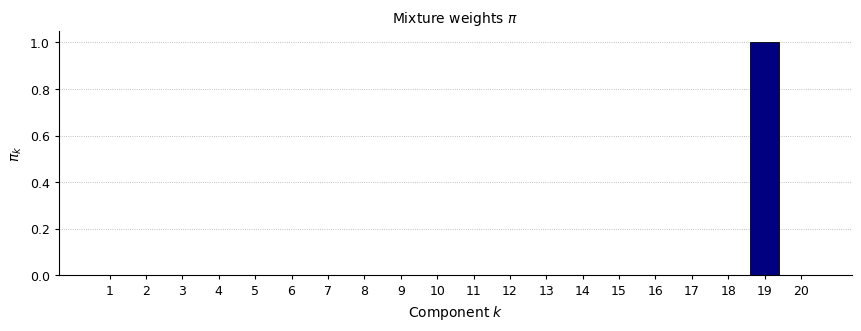

In [21]:
plot_tensor_bars(pi, xticks_step=1, 
                 titles=r"Mixture weights $\pi$", 
                 ylabel=r"$\pi_k$", 
                 xlabel=r"Component $k$",
                 color="navy")

### PCA for distributions 

In [22]:
from utils.viz_gmm import pick_projection
proj, proj_2d = pick_projection(Sigma, pi, max_dim=32)  # (D,d) (D,2)

# projection for each component
mu_proj = mu @ proj        # (K,d)
Sigma_proj = torch.stack([proj.t() @ Sigma[k] @ proj for k in range(K)], dim=0)  # (K,d,d)

# 2-d projection for contour plot
mu_proj_2d = mu @ proj_2d  # (K,2)
Sigma_proj_2d = torch.stack([proj_2d.T @ Sigma[k] @ proj_2d for k in range(K)], dim=0)  # (K,2,2)


(<Figure size 900x1820 with 20 Axes>,
 array([[<Axes: title={'center': 'K=1'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=2'}>, <Axes: title={'center': 'K=3'}>],
        [<Axes: title={'center': 'K=4'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=5'}>, <Axes: title={'center': 'K=6'}>],
        [<Axes: title={'center': 'K=7'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=8'}>, <Axes: title={'center': 'K=9'}>],
        [<Axes: title={'center': 'K=10'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=11'}>,
         <Axes: title={'center': 'K=12'}>],
        [<Axes: title={'center': 'K=13'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=14'}>,
         <Axes: title={'center': 'K=15'}>],
        [<Axes: title={'center': 'K=16'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=17'}>,
         <Axes: title={'center': 'K=18'}>],
        [<Axes: title={'center': 'K=19'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=20'}>, <Axes: >]], d

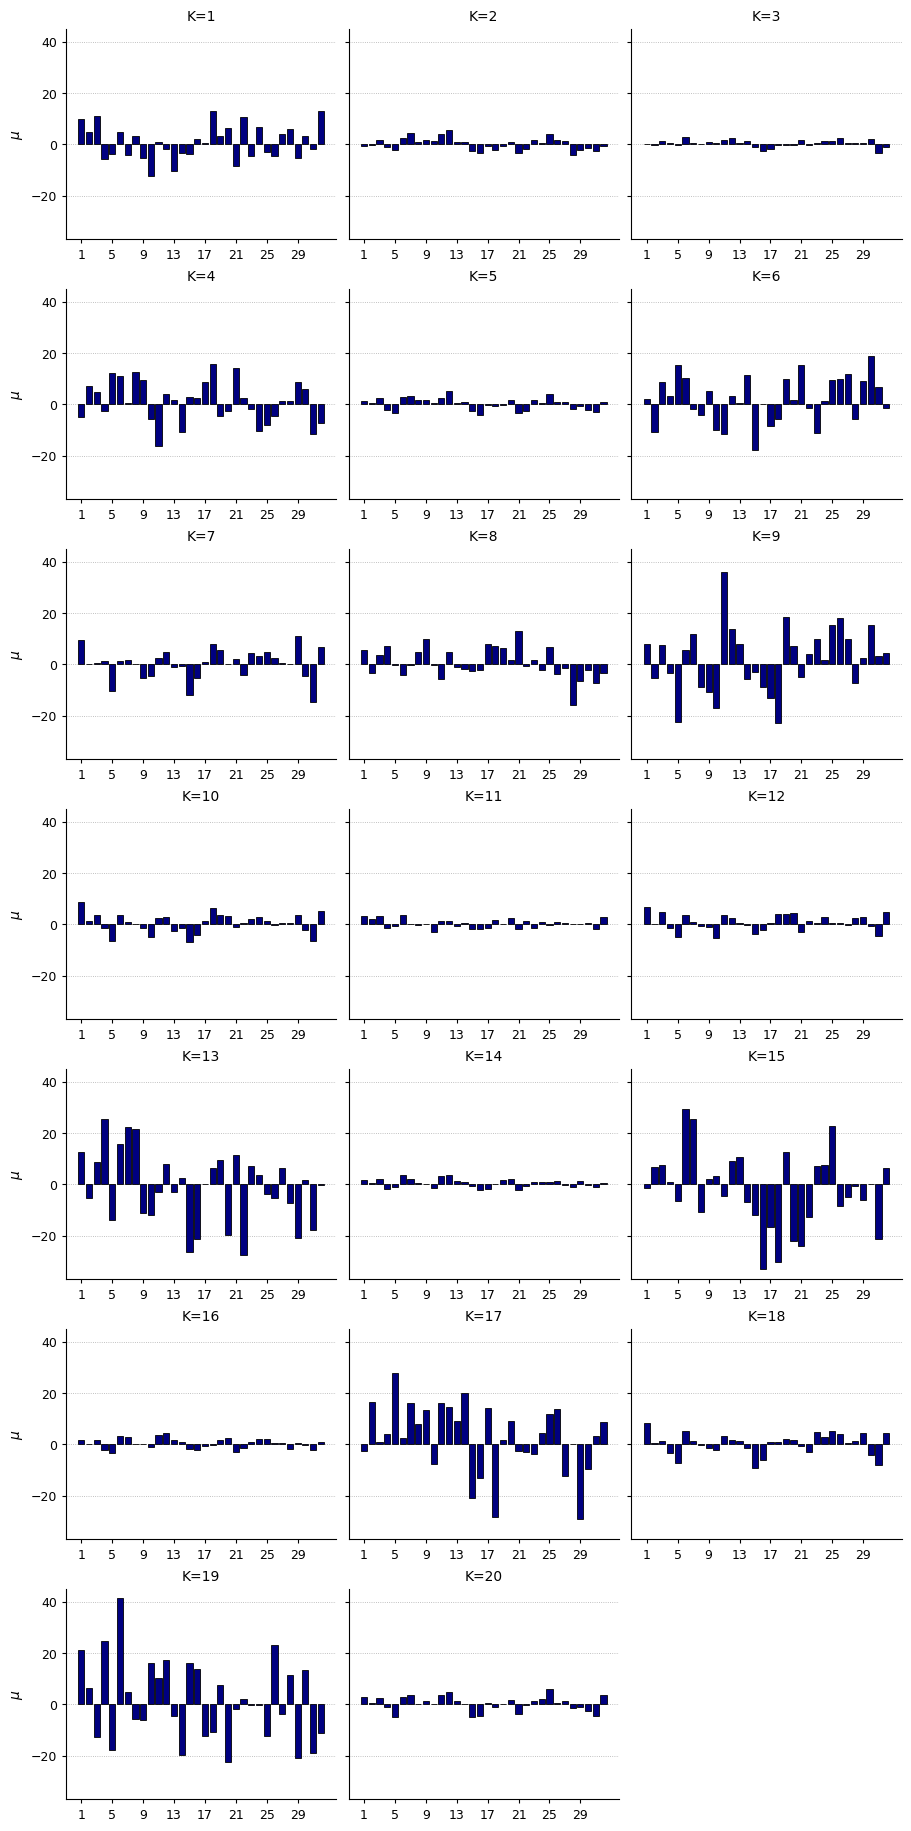

In [23]:
plot_tensor_bars(mu_proj, xticks_step=4, 
                 titles=[f"K={i+1}" for i in range(K)], 
                 ylabel=r"$\mu$",
                 color="navy")

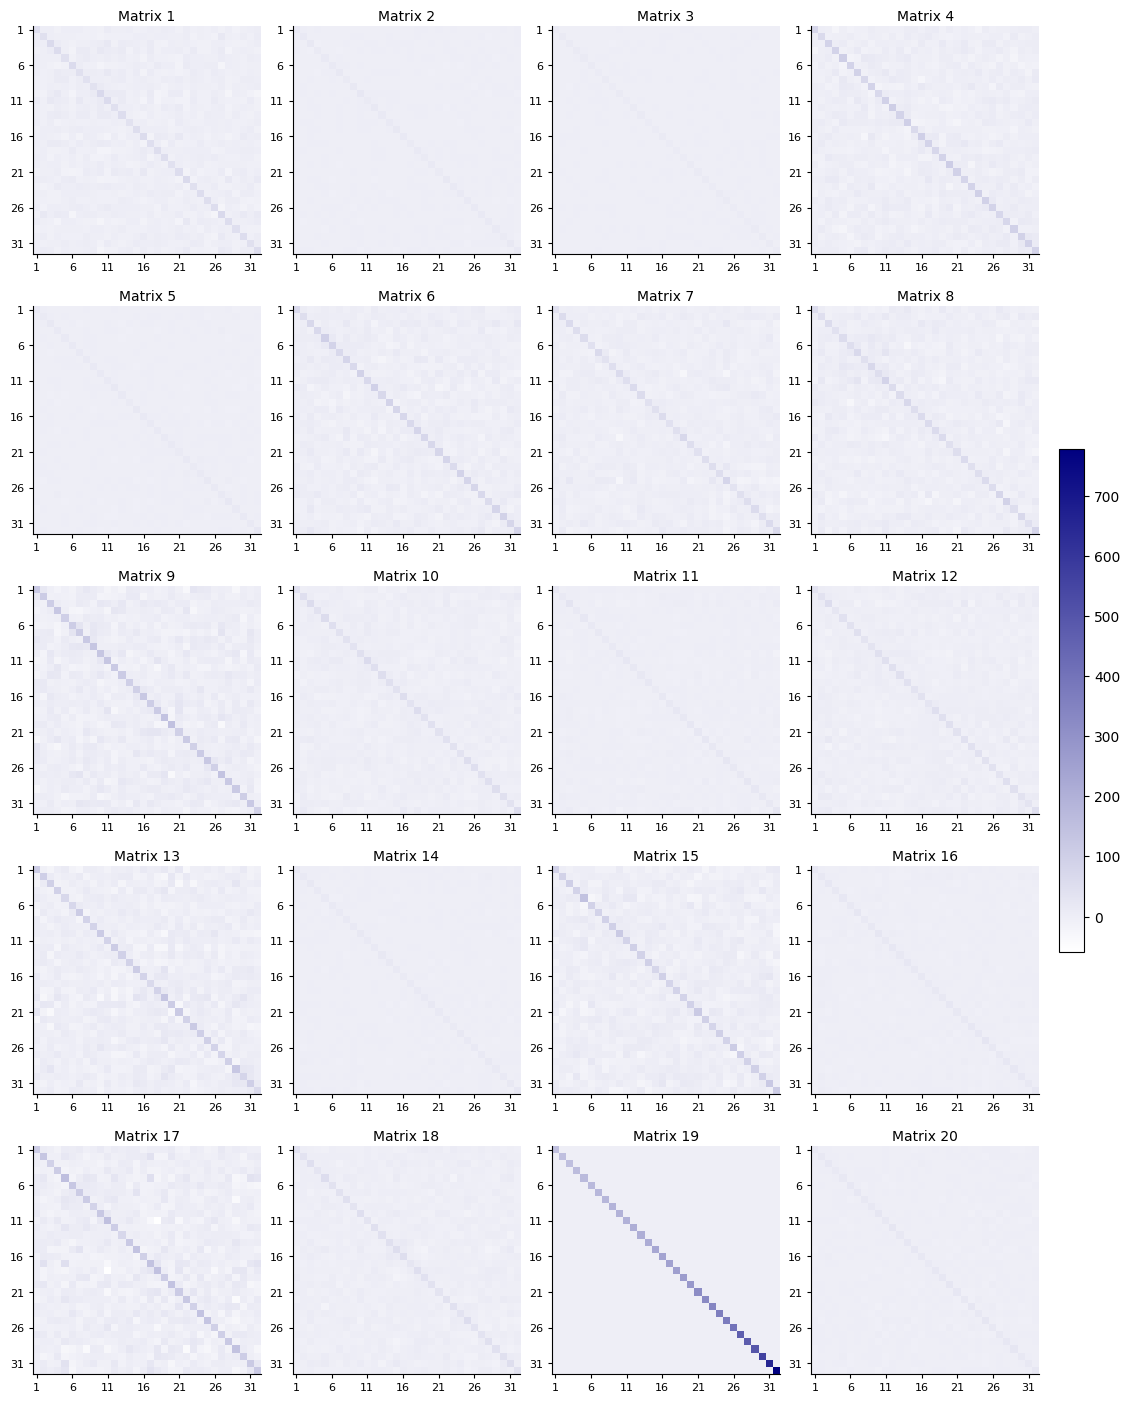

In [24]:
import matplotlib.colors as mcolors
from utils.viz_gmm import plot_tensor_heatmaps
import matplotlib.pyplot as plt

blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white", ["navy", "white"]   # 起点 navy 深蓝, 终点白色
)

plot_tensor_heatmaps(
    Sigma_proj,
    titles=[rf"$\Sigma_{i+1}$" for i in range(3)],
    nrows=5, ncols=4,        # 手动 1 行 3 列
    reverse_cmap=True,       # 颜色对调
    share_color=True,
    xtick_step=5,
    cmap=blue_cmap
)
plt.show()


In [60]:
pi.detach().cpu().numpy(), mu_proj_2d.detach().cpu().numpy(), Sigma_proj_2d.detach().cpu().numpy()  # (K,), (K,2), (K,2,2)

(array([9.9990451e-01, 7.4234401e-07, 9.4784766e-05], dtype=float32),
 array([[ 5.6036005, -3.5720918],
        [ 4.405885 ,  1.0420519],
        [-1.7023841, -5.356113 ]], dtype=float32),
 array([[[ 1.27629623e+01, -1.10417604e-05],
         [-1.09374523e-05,  1.59156065e+01]],
 
        [[ 4.29444933e+00,  3.96872371e-01],
         [ 3.96872371e-01,  4.36998081e+00]],
 
        [[ 4.59327316e+00,  1.73581988e-01],
         [ 1.73582137e-01,  4.15355873e+00]]], dtype=float32))

In [34]:
import numpy as np
from utils import g_ball
def sample_gmm_torch(n_samples, weights, means, covariances, device="cpu", seed=None):
    """
    Sample from a Gaussian Mixture Model (GMM) using PyTorch.
    
    Parameters
    ----------
    n_samples : int
        Total number of samples to generate.
    weights : torch.Tensor, shape (K,)
        Mixture weights of each component, must sum to 1.
    means : torch.Tensor, shape (K, d)
        Mean vectors of each component.
    covariances : torch.Tensor, shape (K, d, d)
        Covariance matrices of each component.
    device : str
        Device to store tensors ("cpu" or "cuda").
    seed : int, optional
        Random seed for reproducibility.
    
    Returns
    -------
    samples : torch.Tensor, shape (n_samples, d)
        Generated samples.
    labels : torch.Tensor, shape (n_samples,)
        Component label of each sample.
    """
    if seed is not None:
        torch.manual_seed(seed)

    K, d = means.shape

    # 1. Sample component indices according to mixture weights
    labels = torch.multinomial(weights, num_samples=n_samples, replacement=True)

    # 2. Generate samples from the corresponding Gaussian distribution
    samples = torch.zeros((n_samples, d), device=device)
    for k in range(K):
        idx = (labels == k).nonzero(as_tuple=True)[0]
        n_k = idx.numel()
        if n_k > 0:
            dist = torch.distributions.MultivariateNormal(
                loc=means[k],
                covariance_matrix=covariances[k]
            )
            samples[idx] = dist.sample((n_k,))

    return samples.to(device), labels.to(device)


# Example: GMM with 2 components
# weights = torch.tensor([0.4, 0.6], dtype=torch.float32)
# means = torch.tensor([[0.0, 0.0], [3.0, 3.0]], dtype=torch.float32)
# covariances = torch.tensor([[[1.0, 0.5], [0.5, 1.0]], 
#                             [[1.0, -0.3], [-0.3, 1.0]]], dtype=torch.float32)


# Split into x and y for plotting

samples, labels = sample_gmm_torch(2000, pi.cpu(), mu_proj_2d.cpu(), Sigma_proj_2d.cpu(), seed=42)
samples = g_ball(samples, gamma=eva.gamma, norm_type=eva.norm)

samples = samples.numpy()
# Split into x and y for plotting
x, y = samples[:, 0], samples[:, 1]

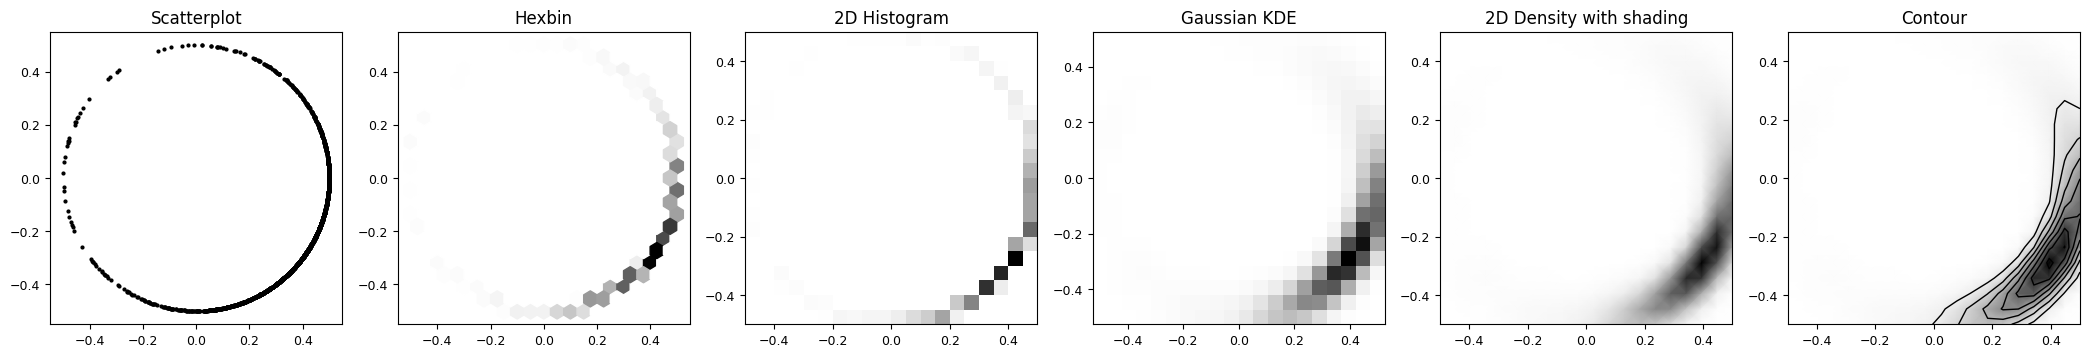

In [35]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde


fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(21, 5))


axes[0].set_title('Scatterplot')
axes[0].plot(x, y, 'o', color='black', markersize=2)


nbins = 20
axes[1].set_title('Hexbin')
axes[1].hexbin(x, y, gridsize=nbins, cmap='Greys')


axes[2].set_title('2D Histogram')
axes[2].hist2d(x, y, bins=nbins, cmap='Greys')


k = kde(samples.T)  # samples shape: (N, 2)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)


axes[3].set_title('Gaussian KDE')
axes[3].pcolormesh(xi, yi, zi, cmap='Greys')


axes[4].set_title('2D Density with shading')
axes[4].pcolormesh(xi, yi, zi, shading='gouraud', cmap='Greys')


axes[5].set_title('Contour')

axes[5].pcolormesh(xi, yi, zi, shading='gouraud', cmap='Greys')

axes[5].contour(xi, yi, zi, levels=10, colors='black', linewidths=1)


for ax in axes:
    ax.set_aspect('equal')       
    ax.tick_params(labelsize=9)  

plt.tight_layout()
plt.show()
